In [26]:
import pylab as plt
import numpy as np
import proposal as pp  #installed with pip
import scipy
from scipy import interpolate

In [27]:
StepSize=50

eps=0.1   # This is a trick to stop divide by zero errors
MinX=MinY=-1500-eps
MaxX=MaxY=1500+eps
m_to_cm=100
GeV=1000

In [28]:
#This is a toy model depth map
def ExampleHeightFunction():
    def SampleFrom(x,y):
        return 850+400*(x/MaxX)-300*((y-MaxX/3)**2)/(MaxX**2)
    [x,y]=np.meshgrid(np.arange(MinX,MaxX,StepSize),np.arange(MinY,MaxY,StepSize))
    return [x,y,SampleFrom(x,y)]

In [29]:
#You will replace this with the real height map in (list of xs) (list of yz) (list of zs) format
x,y,z=ExampleHeightFunction()

<ipython-input-30-7811a412ca32>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,z)


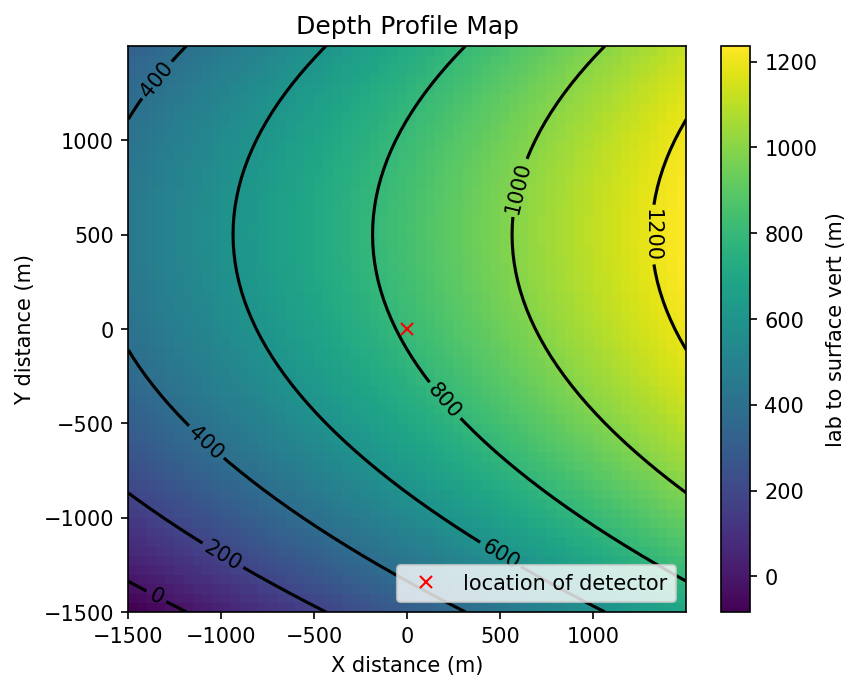

In [30]:
# Plot the height map
plt.figure(figsize=(6,5),dpi=150)
plt.pcolormesh(x,y,z)

plt.colorbar(label='lab to surface vert (m)')
CS=plt.contour(x,y,z,colors='black')
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')


plt.xlabel("X distance (m)")
plt.ylabel("Y distance (m)")
plt.title("Depth Profile Map")
plt.plot([0],[0],'x',label='location of detector',color='red')
plt.legend(loc='lower right')

In [31]:
#Find the thetas and phis and distance through rock for each grid square
phioffset=0                      # Orientation of detector relative to map - you need to figure this out.
rho=(x**2+y**2)**0.5             # cylindrical rho coordinate
theta=np.arctan(rho/z)           # spherical theta coordinate (0 = downgoing)
phi = np.arctan(y/x) + phioffset # spherical phi coordinate
distancetodetector = np.sqrt(z**2+x**2+y**2)

In [32]:
sum(np.isnan(phi))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

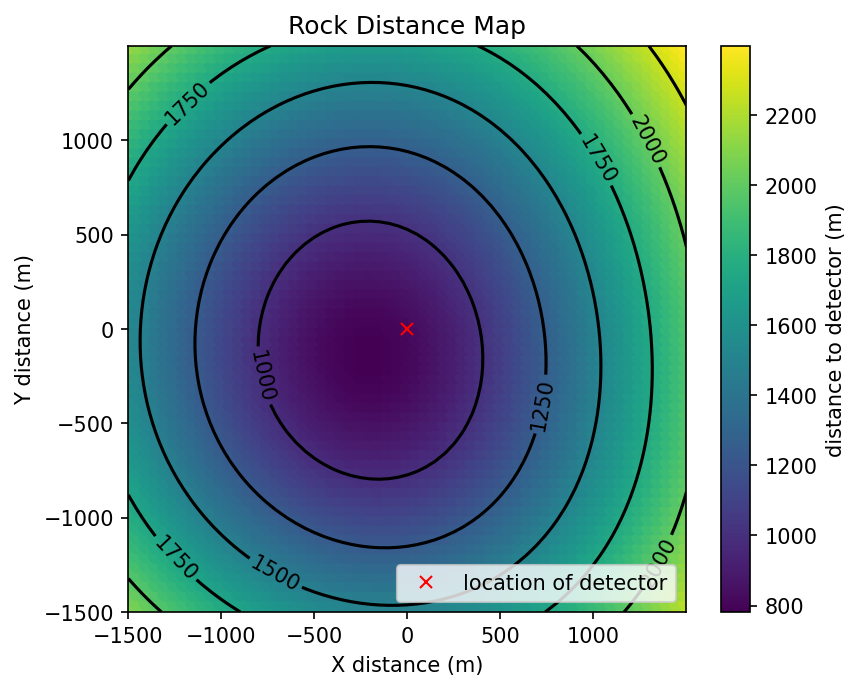

In [33]:
#Plot the distance from the surface to the lab at each place in XY

plt.figure(figsize=(6,5),dpi=150)
plt.scatter(x,y,StepSize,distancetodetector)

plt.colorbar(label='distance to detector (m)')
CS=plt.contour(x,y,distancetodetector,colors='black')
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')


plt.xlabel("X distance (m)")
plt.ylabel("Y distance (m)")
plt.title("Rock Distance Map")
plt.plot([0],[0],'x',label='location of detector',color='red')
plt.legend(loc='lower right')

In [34]:
# continuously interpolate rock length and depth functions so we can sample at any X,Y
rocklength=scipy.interpolate.interp2d(x,y,distancetodetector)
depth     =scipy.interpolate.interp2d(x,y,z)

# a handy function to go from surface position to angles, depth, distance
def GetMuonInfo(startMuon):
    depthMuon   = np.round(depth(*startMuon)[0],2)
    distMuon    = np.round(rocklength(*startMuon)[0],2)
    thMuon      = np.round(np.arctan((startMuon[0]**2+startMuon[1]**2)**0.5/depthMuon),2)
    phiMuon     = np.round(np.arctan(startMuon[1]/startMuon[0]),2)
    return thMuon,phiMuon,depthMuon,distMuon

In [79]:
#This function does the business of calling PROPOSAL.
# It is configured in config.json to propagate the muon through a giant block of "standard rock"

def PropagateMuons(MuonEnergyToSimulate,DistToDetector,NumberToRun=1000):
    mu_def = pp.particle.MuMinusDef()
    prop = pp.Propagator(
        particle_def=mu_def,
        config_file="./config.json"   #in the PROPOSAL resources directory
    )

    mu = pp.particle.DynamicData(mu_def.particle_type)

    mu.energy = MuonEnergyToSimulate
    mu.direction = pp.Vector3D(0, 0, -1)

    mu_position = []
    mu_energy = []

    for i in range(NumberToRun):
        sec = prop.propagate(mu,DistToDetector)
        slop=100
        if(np.abs(sec.position[-1].magnitude()-DistToDetector)<slop):
            mu_energy.append(sec.energy[-1])
            mu_position.append(sec.position[-1].magnitude()-DistToDetector)
    return mu_energy,mu_position

In [63]:
#How many muons to propagate at each point
NumToRun=1000


theta, phi, depth, distance to det:  0.69 -0.79 849.97 1105.67


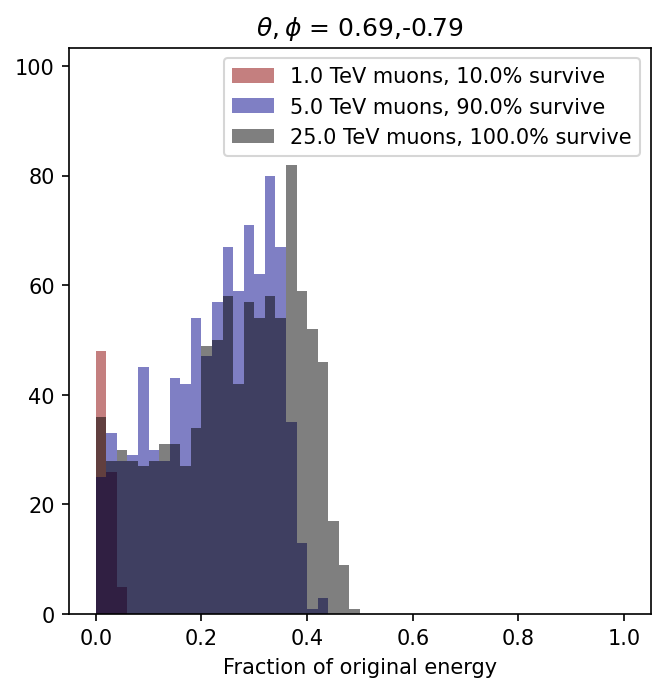

In [68]:
#Decide on a place to start a muon from and get its angles and distances:
startMuon   = (500,-500)
thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
print("theta, phi, depth, distance to det: ", thMuon,phiMuon,depthMuon,distMuon)


# Run a few energies and make a plot

plt.figure(figsize=(5,5),dpi=150)

E=1000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000))
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkRed')

E=5000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000))
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkBlue')

E=25000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000))
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='Black')


plt.legend(loc='upper right')
plt.xlabel("Fraction of original energy")
plt.title(r"$\theta,\phi$ = "+str(thMuon)+"," +str(phiMuon))
plt.ylim(0,plt.gca().get_ylim()[1]*1.2)
plt.show()



theta, phi, depth, distance to det:  0.96 -0.32 1116.59 1935.6


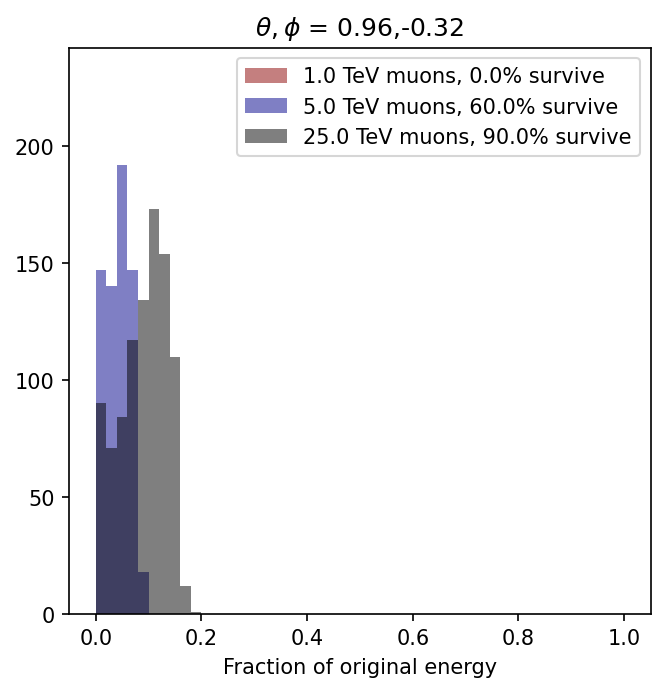

In [69]:
#Try a different place further away, for comparison - we should see more absorption

startMuon   = (1500,-500)
thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
print("theta, phi, depth, distance to det: ", thMuon,phiMuon,depthMuon,distMuon)

plt.figure(figsize=(5,5),dpi=150)

E=1000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000))
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkRed')

E=5000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000))
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkBlue')

E=25000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000))
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='Black')


plt.legend(loc='upper right')
plt.xlabel("Fraction of original energy")
plt.title(r"$\theta,\phi$ = "+str(thMuon)+"," +str(phiMuon))
plt.ylim(0,plt.gca().get_ylim()[1]*1.2)


plt.show()


